In [1]:
from lime import lime_tabular
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('bases_full.csv')

In [4]:
df = df[[
    'cod_ide', 
    'Cargo',
    'Edad',
    'Genero', 
    'EstadoCivil',
    'nProductividad',
    'nProbMoraNoHeredada', 
    'nProbMoraHeredada',
    'ingresoef', 
    'pregunta_1', 
    'pregunta_2', 
    'pregunta_3',
    'pregunta_4', 
    'pregunta_5', 
    'pregunta_6', 
    'pregunta_7', 
    'pregunta_8',
    'pregunta_9', 
    'pregunta_10', 
    'pregunta_11', 
    'pregunta_12',
    'pregunta_13', 
    'pregunta_14', 
    'pregunta_15', 
    'pregunta_16',
    'pregunta_17', 
    'pregunta_18', 
    'pregunta_19', 
    'pregunta_20',
    'pregunta_21', 
    'pregunta_22', 
    'pregunta_23', 
    'pregunta_24',
    'pregunta_25', 
    'pregunta_26', 
    'pregunta_27', 
    'pregunta_28',
    'pregunta_29', 
    'pregunta_30'
]]

In [5]:
pandas_profiling.ProfileReport(df)

In [6]:
dtypes = ['category', 'bool', 'object']
df_categorical = df.loc[:, [col for col in df.columns]].select_dtypes(include=dtypes)
df_categorical.head()
df_categorical.shape
list(df_categorical)

cod_ide                         Cargo     Genero EstadoCivil  \
0  C00000001  ASESOR COMERCIAL FUNCIONARIO  Masculino     Soltero   
1  C00000002       ASESOR COMERCIAL MASTER   Femenino       Otros   
2  C00000003       ASESOR COMERCIAL MASTER   Femenino      Casado   
3  C00000004  ASESOR COMERCIAL FUNCIONARIO   Femenino     Soltero   
4  C00000005  ASESOR COMERCIAL FUNCIONARIO   Femenino     Soltero   

  nProbMoraNoHeredada nProbMoraHeredada ingresoef  
0               bueno              malo        NO  
1                malo              malo        NO  
2                malo             bueno        NO  
3               bueno              malo        NO  
4                malo             bueno        NO

(768, 7)

['cod_ide',
 'Cargo',
 'Genero',
 'EstadoCivil',
 'nProbMoraNoHeredada',
 'nProbMoraHeredada',
 'ingresoef']

In [7]:
df = pd.get_dummies(df, columns=['Cargo', 'Genero', 'EstadoCivil'], prefix='D_')

for feature in ['nProbMoraNoHeredada', 'nProbMoraHeredada']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'bueno': 1, 'malo': 0 })
    
df.loc[:, 'ingresoef'] = df.loc[:, 'ingresoef'].map({ 'SI': 1, 'NO': 0 })

df_categorical = df.loc[:, [col for col in list(df) if 
                            col in list(df_categorical) or 
                            col.startswith('D_') or
                            col.startswith('pregunta')]]

for feature in list(df_categorical):
    if feature != 'cod_ide' and not feature.startswith('pregunta'):
        df[feature].value_counts()

0    417
1    351
Name: nProbMoraNoHeredada, dtype: int64

1    402
0    366
Name: nProbMoraHeredada, dtype: int64

0    584
1    184
Name: ingresoef, dtype: int64

0    707
1     61
Name: D__ASESOR COMERCIAL FUNCIONARIO, dtype: int64

0    611
1    157
Name: D__ASESOR COMERCIAL JUNIOR 1, dtype: int64

0    528
1    240
Name: D__ASESOR COMERCIAL JUNIOR 2, dtype: int64

0    637
1    131
Name: D__ASESOR COMERCIAL MASTER, dtype: int64

0    589
1    179
Name: D__ASESOR COMERCIAL SENIOR, dtype: int64

0    530
1    238
Name: D__Femenino, dtype: int64

1    530
0    238
Name: D__Masculino, dtype: int64

0    621
1    147
Name: D__Casado, dtype: int64

0    676
1     92
Name: D__Otros, dtype: int64

1    529
0    239
Name: D__Soltero, dtype: int64

In [8]:
dtypes = ['number']
df_numeric = df.loc[:, [col for col in df.columns if col not in df_categorical.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

Edad  nProductividad
0    36        0.823077
1    46        0.750000
2    58        0.827303
3    34        1.100000
4    36        0.906250

(768, 2)

['Edad', 'nProductividad']

In [9]:
df_discrete = df.loc[:, [col for col in df_numeric.columns if (df[col].dropna() - df[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

Edad
0    36
1    46
2    58
3    34
4    36

(768, 1)

['Edad']

In [10]:
df_continuous = df.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

nProductividad
0        0.823077
1        0.750000
2        0.827303
3        1.100000
4        0.906250

(768, 1)

['nProductividad']

## Correlations

In [11]:
def make_correlation_graphic(df, title):
    corr = df.corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    ax.set_title(title)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

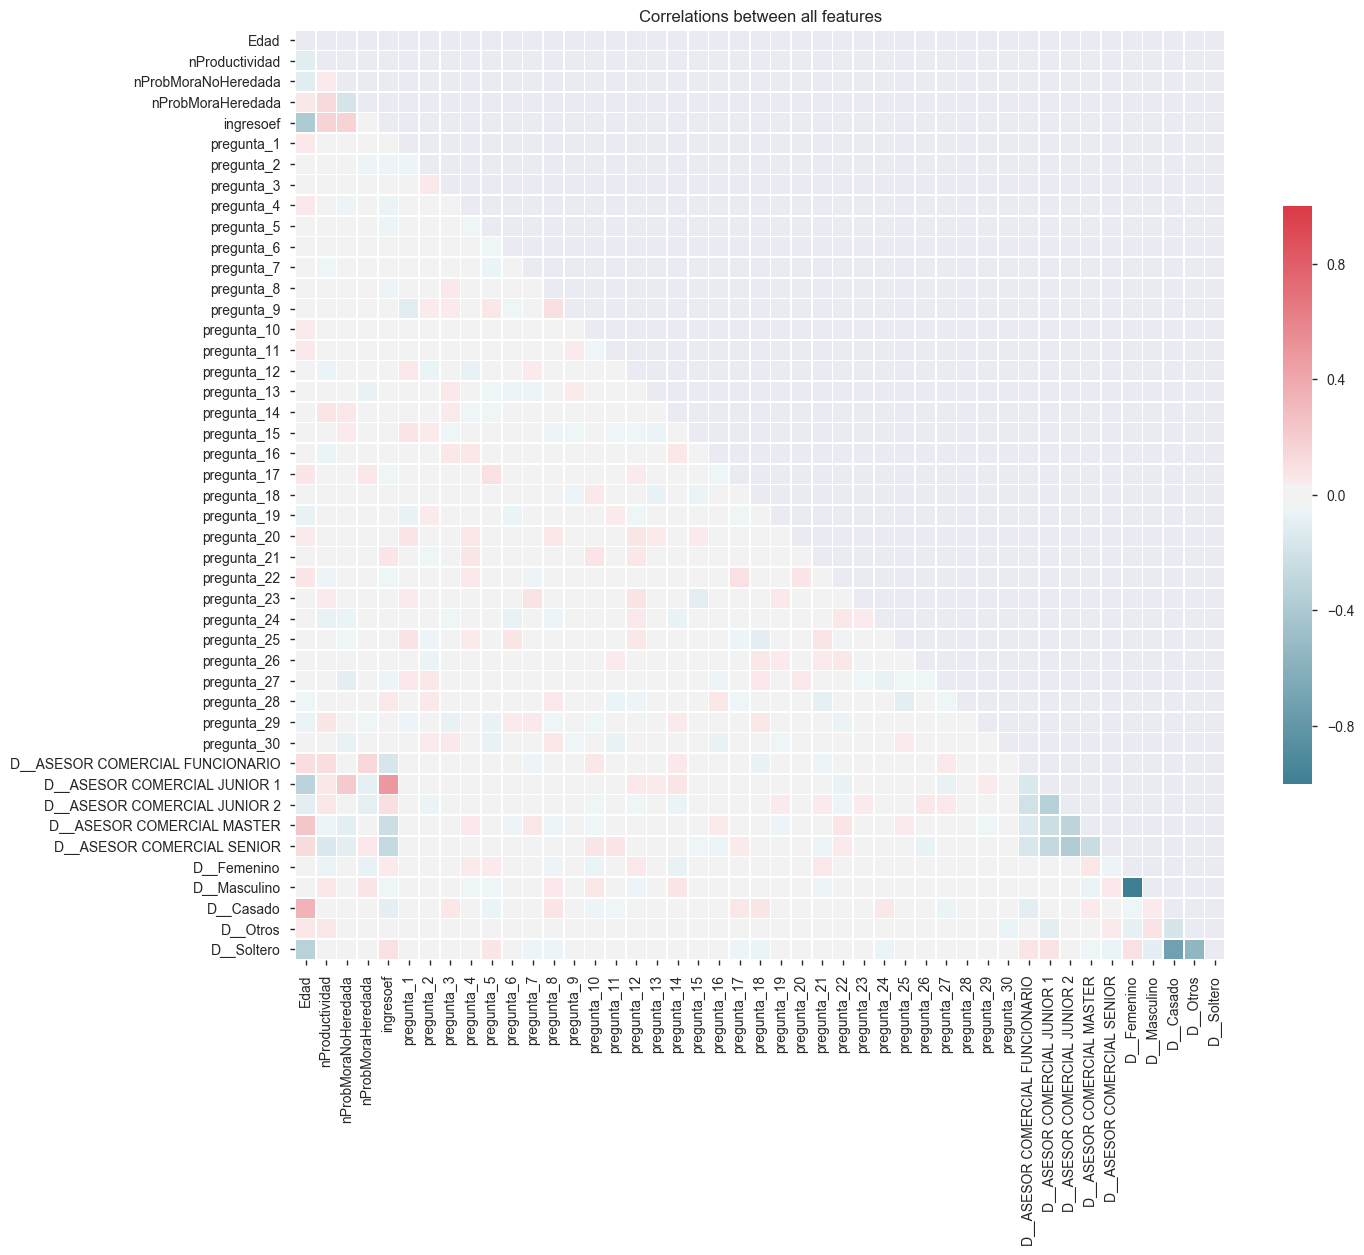

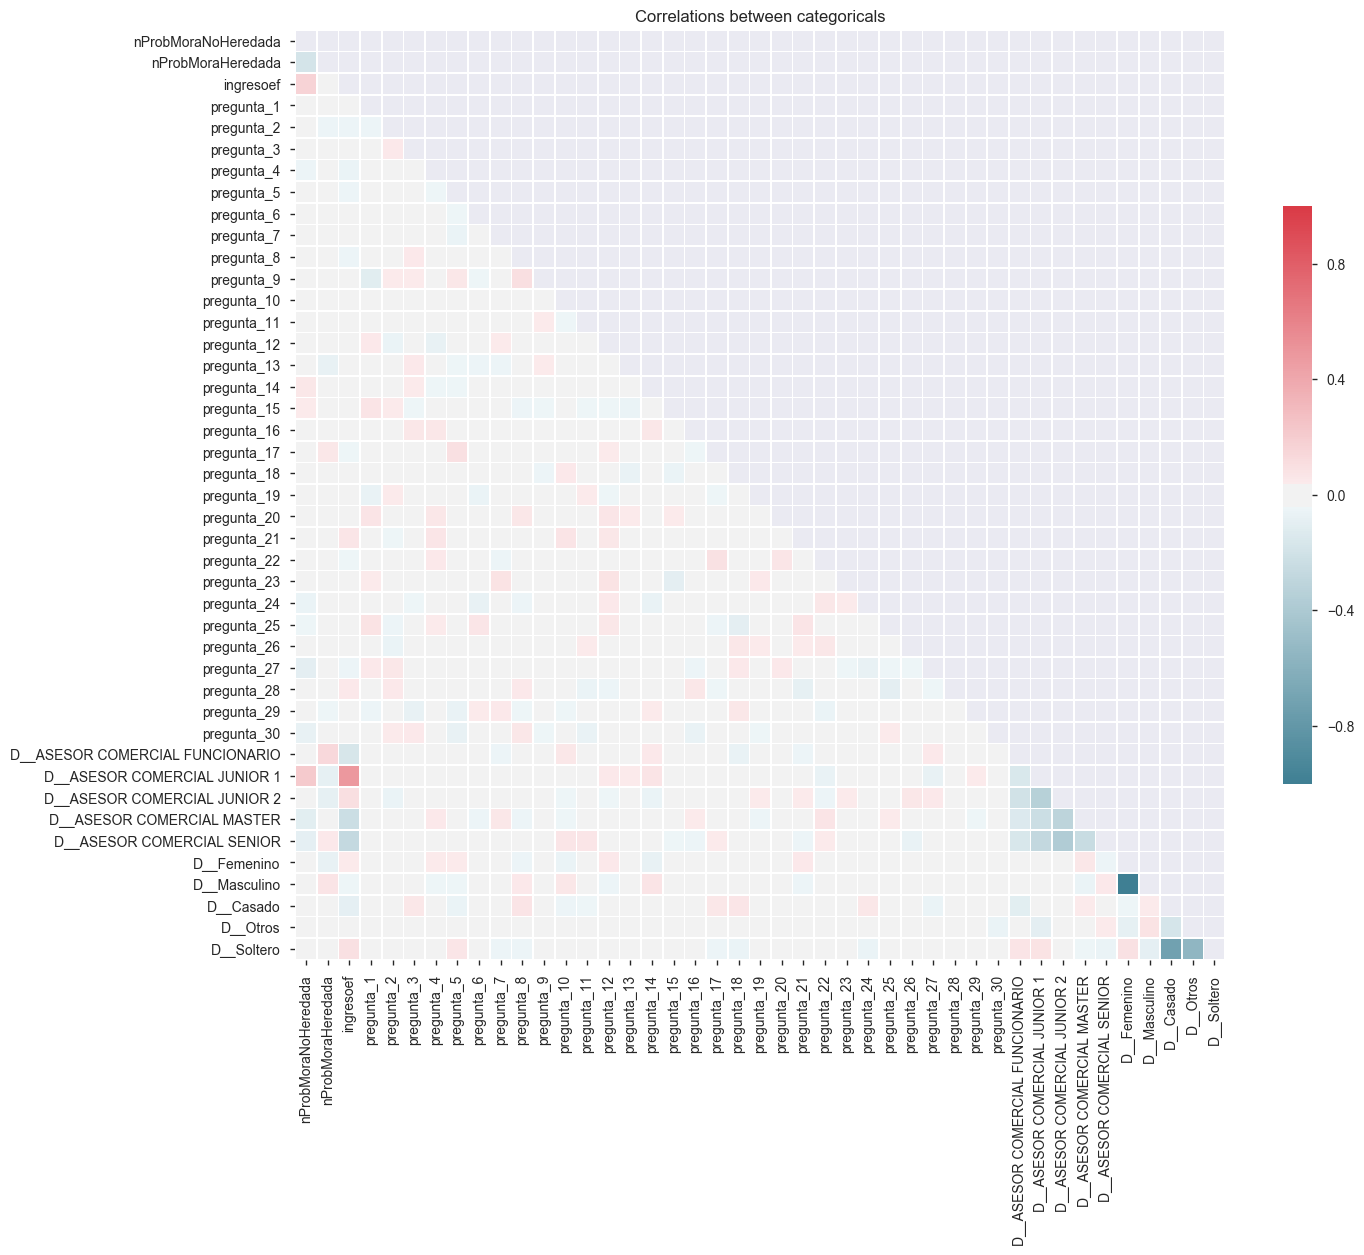

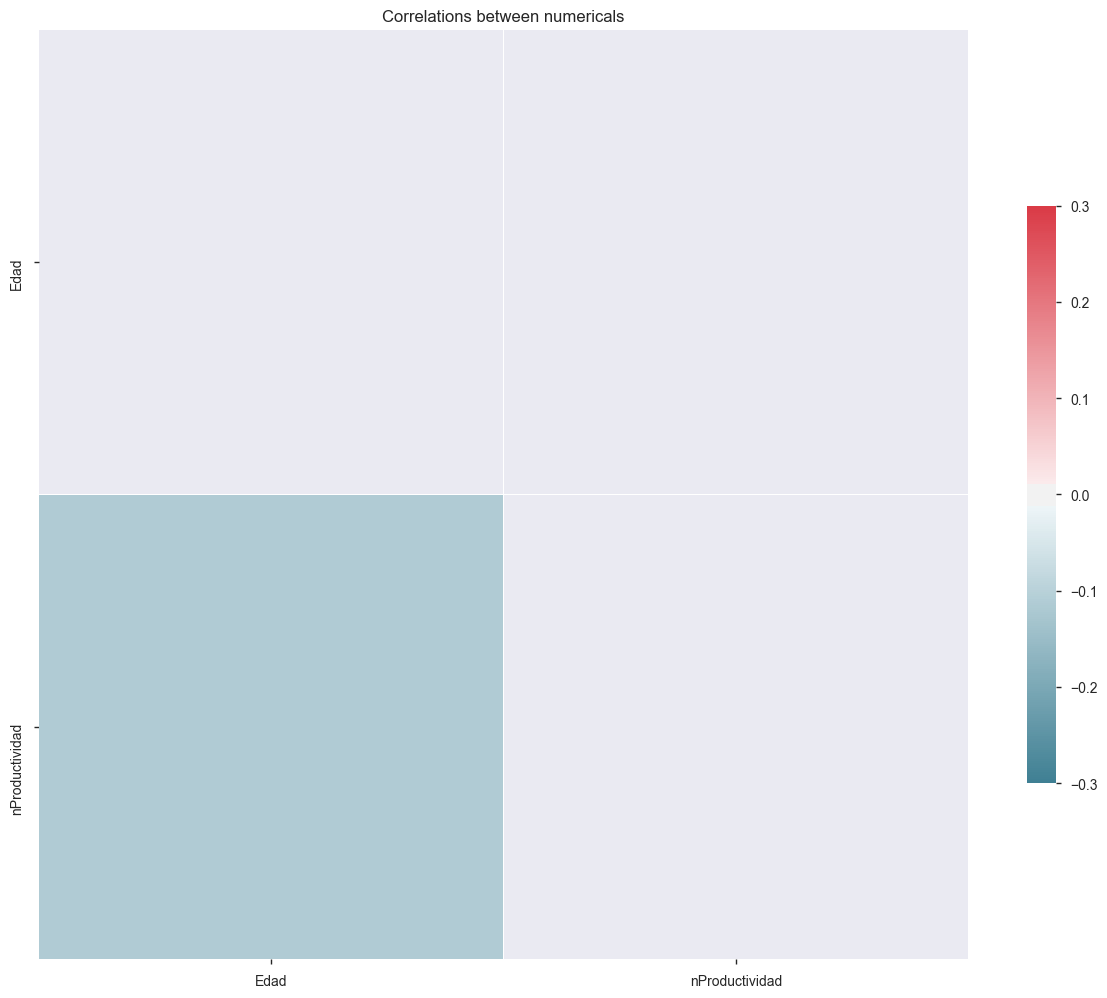

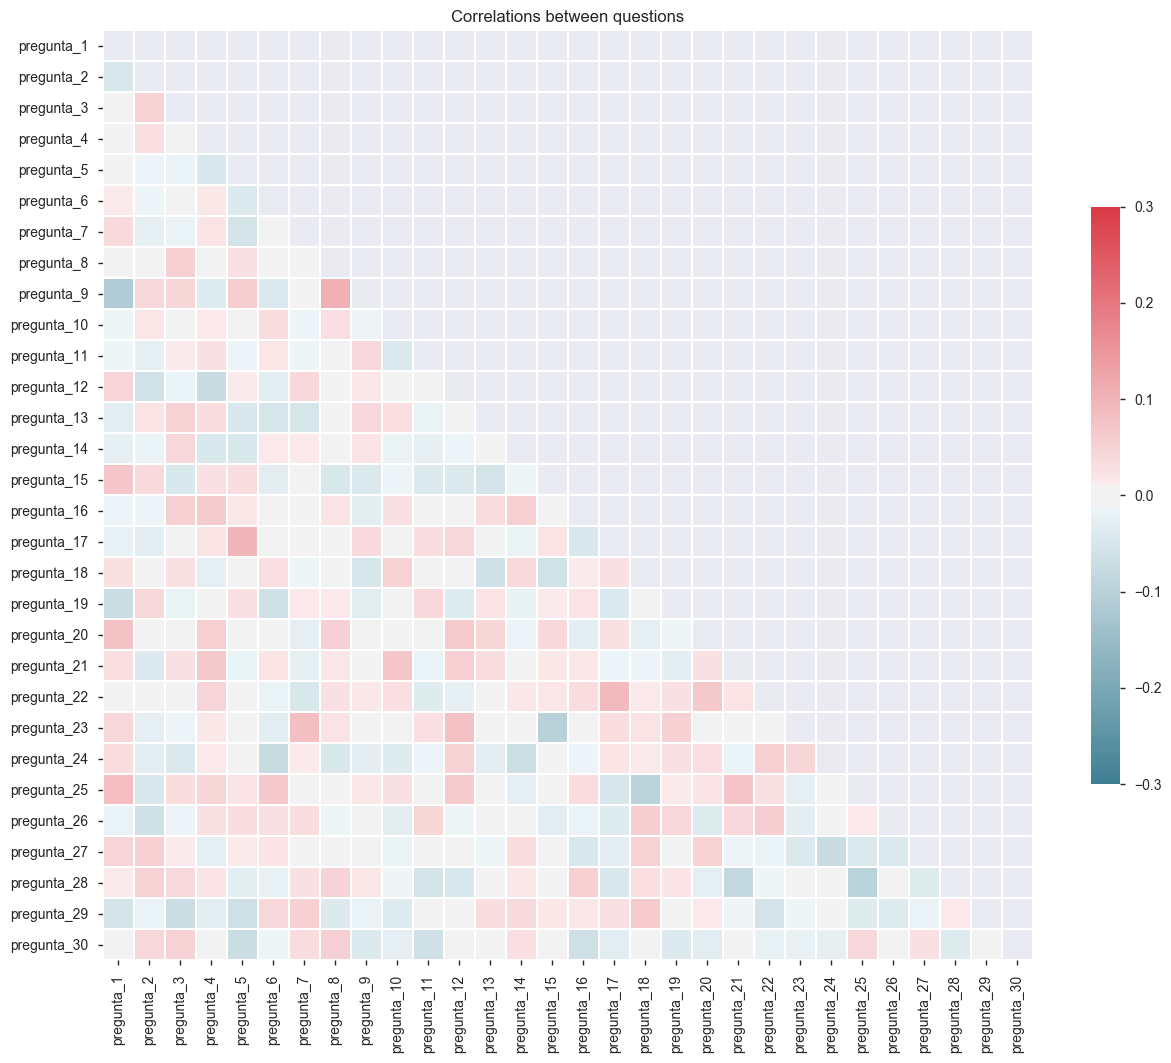

In [12]:
make_correlation_graphic(df, 'Correlations between all features')
make_correlation_graphic(df_categorical, 'Correlations between categoricals')
make_correlation_graphic(df_numeric, 'Correlations between numericals')

df_questions = df_categorical.loc[:, [col for col in df_categorical.columns if col.startswith('pregunta')]]
make_correlation_graphic(df_questions, 'Correlations between questions')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


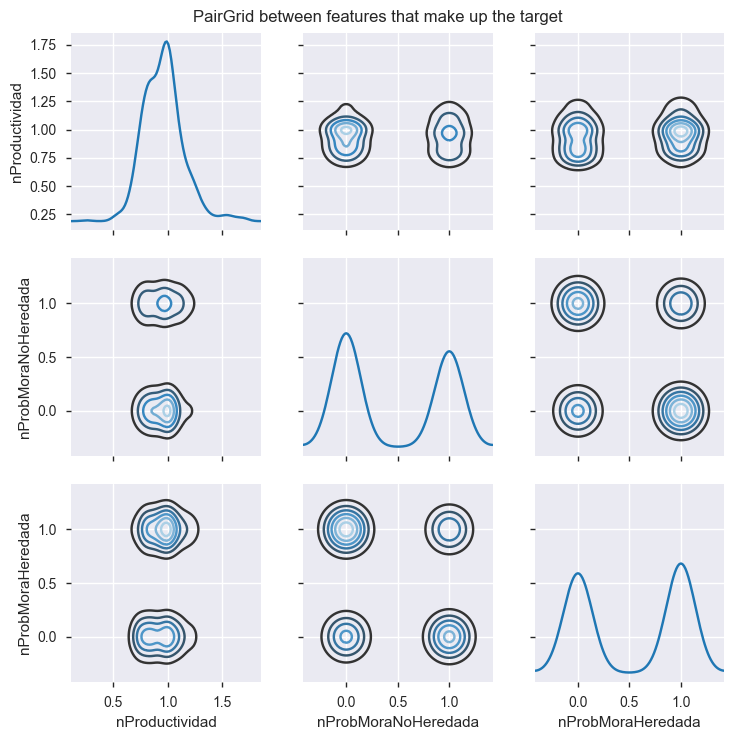

In [13]:
g = sns.PairGrid(df[['nProductividad', 'nProbMoraNoHeredada', 'nProbMoraHeredada']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('PairGrid between features that make up the target')

In [14]:
df['PM'] = df['nProbMoraHeredada'] + df['nProbMoraNoHeredada']

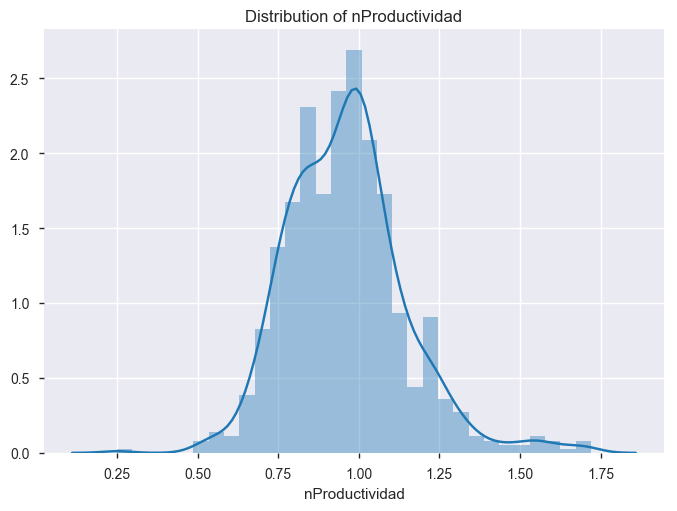

In [15]:
g = sns.distplot(df['nProductividad'])
g.set_title('Distribution of nProductividad')

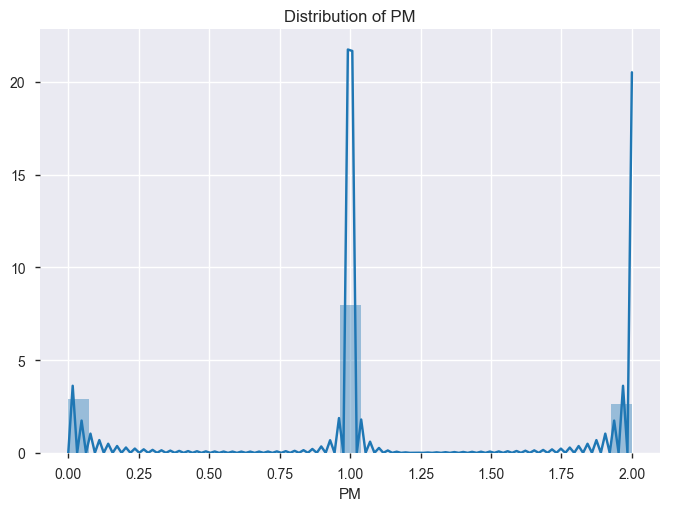

In [16]:
g = sns.distplot(df['PM'])
g.set_title('Distribution of PM')

In [63]:
pair_vars = list(df_continuous)
pair_vars.remove('nProductividad')
for feature in pair_vars:
    plt.figure()
    g = sns.pairplot(df, x_vars=[feature], y_vars=["nProductividad"], hue="PM", size=10, aspect=1)
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('{} vs. nProductividad vs. PM'.format(feature))

NameError: name 'df_continuous' is not defined

# Creating target

In [18]:
df['PM'].value_counts()

1    455
0    164
2    149
Name: PM, dtype: int64

In [19]:
def convert_score(el):
    return 1/(el + 1)

In [20]:
df.loc[:, 'PM'] = df.loc[:, 'PM'].apply(convert_score)

In [21]:
df['PM'].value_counts()

0.500000    455
1.000000    164
0.333333    149
Name: PM, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


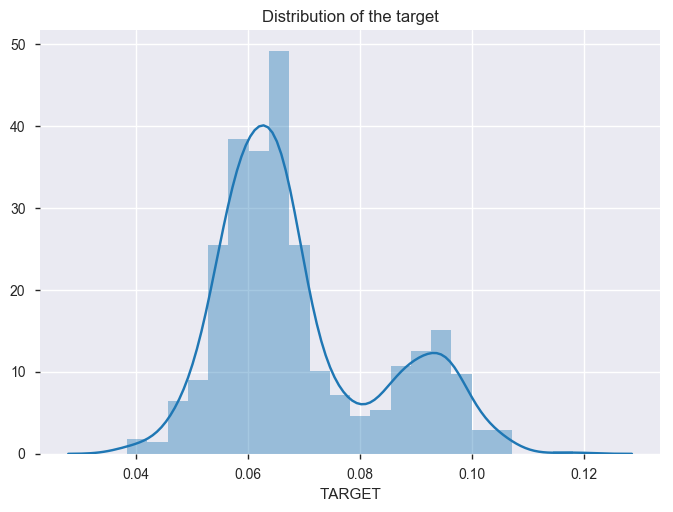

In [22]:
df['N_nProductividad'] = normalize(df['nProductividad'])[0]
df['N_PM'] = normalize(df['PM'])[0]
df['TARGET'] = df['N_nProductividad'] + df['N_PM']
g = sns.distplot(df['TARGET'])
g.set_title('Distribution of the target')

In [23]:
df = df.drop(['PM', 'N_nProductividad', 'N_PM', 'nProductividad', 'nProbMoraHeredada', 'nProbMoraNoHeredada'], axis=1)

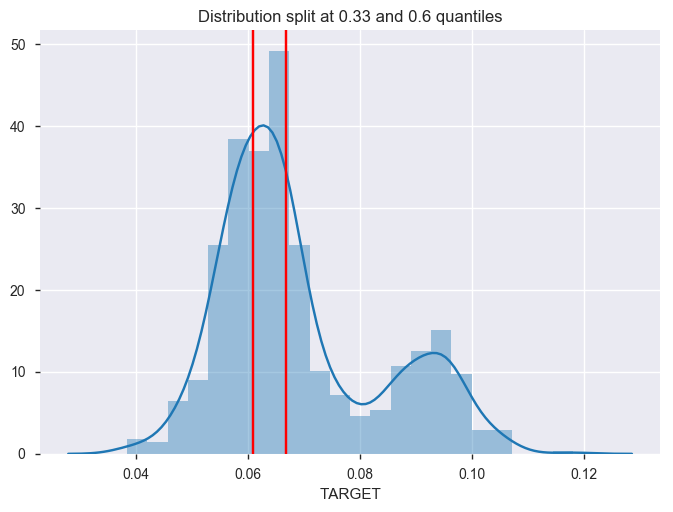

In [24]:
margin1 = 0.33
margin2 = 0.60

g = sns.distplot(df['TARGET'])
g.set_title('Distribution split at {} and {} quantiles'.format(margin1, margin2))
sns.plt.axvline(df['TARGET'].quantile(margin1), color='r')
sns.plt.axvline(df['TARGET'].quantile(margin2), color='r')

plt.show()

In [25]:
df[['cod_ide', 'TARGET']].head()

cod_ide    TARGET
0  C00000001  0.059532
1  C00000002  0.085980
2  C00000003  0.059688
3  C00000004  0.069756
4  C00000005  0.062603

In [26]:
categories = ['bad', 'normal', 'good']
cuts = [min(df['TARGET']), df['TARGET'].quantile(margin1), df['TARGET'].quantile(margin2), max(df['TARGET'])]
df['TARGET'] = pd.cut(df['TARGET'], cuts, labels=categories, include_lowest=True)

In [27]:
df[['cod_ide', 'TARGET']].head()

cod_ide  TARGET
0  C00000001     bad
1  C00000002    good
2  C00000003     bad
3  C00000004    good
4  C00000005  normal

In [28]:
df.loc[:, 'TARGET'] = df.loc[:, 'TARGET'].map({
    'bad': 0,
    'normal': 1,
    'good': 2
})
df['TARGET'].value_counts()

2    307
0    258
1    203
Name: TARGET, dtype: int64

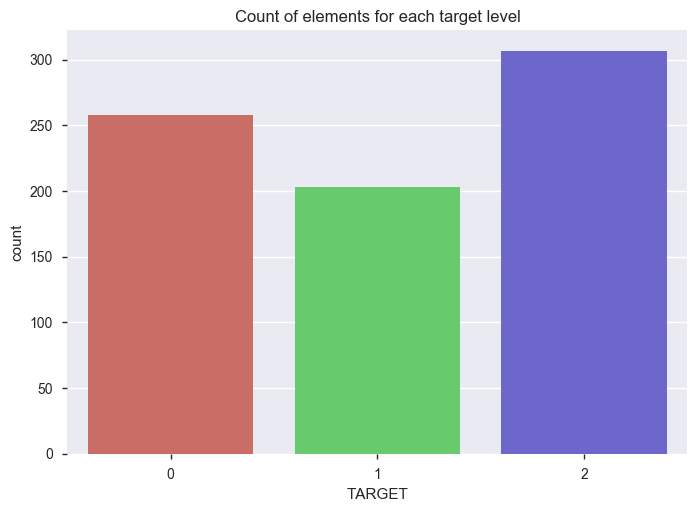

In [29]:
g = sns.countplot(x="TARGET", data=df, palette='hls')
g.set_title('Count of elements for each target level')

In [31]:
df = df.drop(['cod_ide'], axis=1)

In [32]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [33]:
X.shape, y.shape

((768, 42), (768,))

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
0    36          0    0.210433    0.014503    0.580707    0.475461   
1    46          0    0.789044    0.343001    0.058207    0.926026   
2    58          0    0.242838    0.528969    0.716495    0.489488   
3    34          0    0.761830    0.494812    0.321391    0.524197   
4    36          0    0.945418    0.833204    0.601921    0.857995   

   pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...     \
0    0.191990    0.208157    0.007626    0.853459   ...      
1    0.871500    0.939968    0.929000    0.118791   ...      
2    0.286807    0.528751    0.501223    0.036598   ...      
3    0.645303    0.035893    0.909352    0.005753   ...      
4    0.926111    0.913815    0.609726    0.990892   ...      

   D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
0                           0                           0            0   
1                           1                           0            1   
2                           1                           0            1   
3                           0                           0            1   
4                           0                           0            1   

   D__Masculino  D__Casado  D__Otros  D__Soltero  cluster  
0             1          0         0           1       -1  
1             0          0         1           0       -1  
2             0          1         0           0       -1  
3             0          0         0           1       -1  
4             0          0         0           1       -1  

[5 rows x 43 columns]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

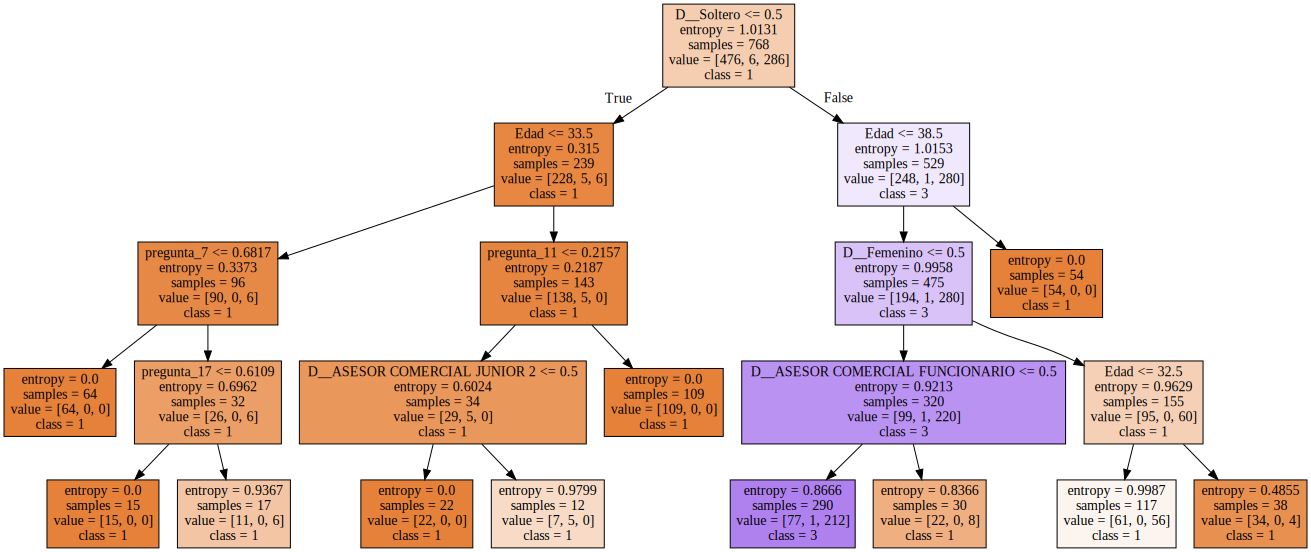

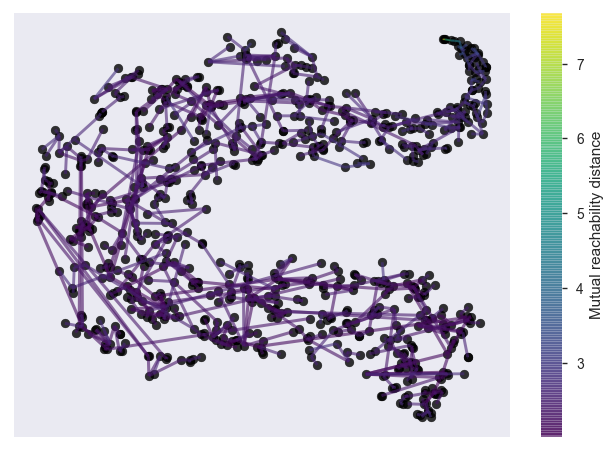

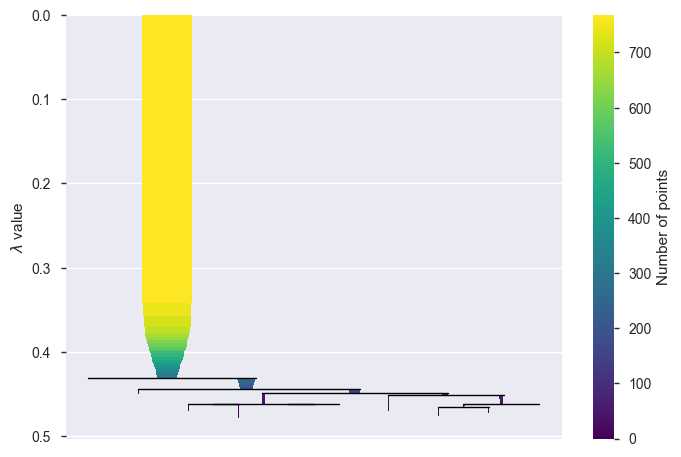

In [34]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())



palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
1     46          0    0.789044    0.343001    0.058207    0.926026   
3     34          0    0.761830    0.494812    0.321391    0.524197   
6     35          0    0.221027    0.442683    0.042709    0.845306   
12    44          0    0.975351    0.448876    0.645230    0.514550   
13    46          0    0.182366    0.394757    0.738945    0.458081   

    pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...    \
1     0.871500    0.939968    0.929000    0.118791   ...     
3     0.645303    0.035893    0.909352    0.005753   ...     
6     0.073125    0.387089    0.836789    0.340532   ...     
12    0.501630    0.906539    0.949537    0.250857   ...     
13    0.429477    0.107369    0.068157    0.299596   ...     

    D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
1                              0                             0   
3                              0                             0   
6                              0                             0   
12                             0                             0   
13                             0                             0   

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
1                            1                           0            1   
3                            0                           0            1   
6                            0                           0            1   
12                           1                           0            1   
13                           1                           0            1   

    D__Masculino  D__Casado  D__Otros  D__Soltero  TARGET  
1              0          0         1           0       2  
3              0          0         0           1       2  
6              0          1         0           0       2  
12             0          1         0           0       2  
13             0          0         0           1       2  

[5 rows x 43 columns]

1     1.0
3    -1.0
6    -1.0
12   -1.0
13   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

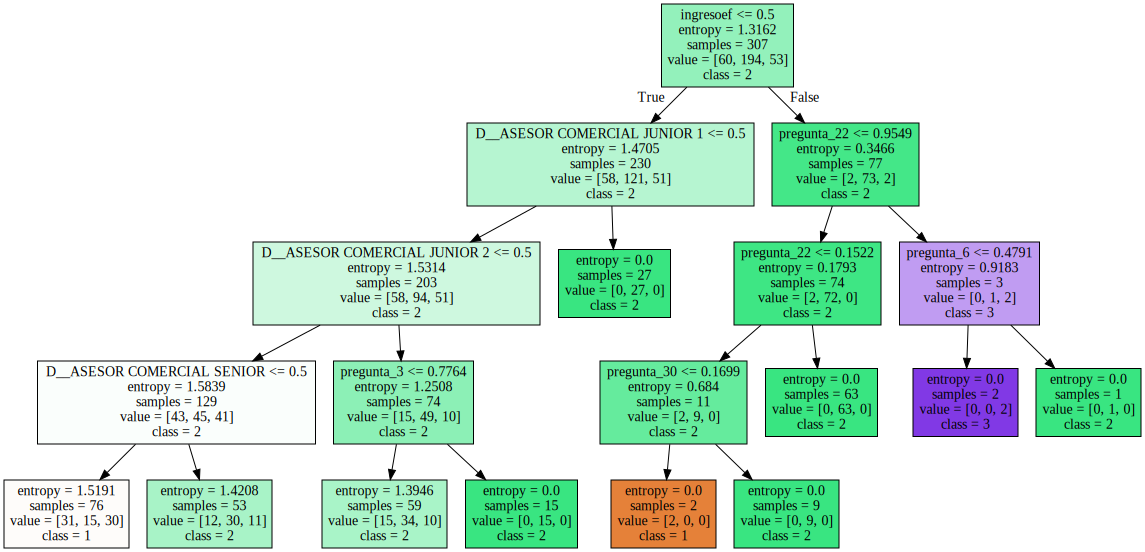

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
0     36          0    0.210433    0.014503    0.580707    0.475461   
2     58          0    0.242838    0.528969    0.716495    0.489488   
8     41          0    0.113082    0.217811    0.570358    0.059313   
9     42          0    0.872726    0.196752    0.718091    0.307564   
11    33          0    0.462763    0.730985    0.565522    0.622575   

    pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...    \
0     0.191990    0.208157    0.007626    0.853459   ...     
2     0.286807    0.528751    0.501223    0.036598   ...     
8     0.794239    0.425821    0.976964    0.074504   ...     
9     0.941359    0.259736    0.217433    0.567548   ...     
11    0.603140    0.679366    0.042535    0.176089   ...     

    D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
0                              0                             0   
2                              0                             0   
8                              0                             1   
9                              0                             0   
11                             0                             0   

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
0                            0                           0            0   
2                            1                           0            1   
8                            0                           0            0   
9                            0                           1            0   
11                           1                           0            1   

    D__Masculino  D__Casado  D__Otros  D__Soltero  TARGET  
0              1          0         0           1       0  
2              0          1         0           0       0  
8              1          0         1           0       0  
9              1          0         0           1       0  
11             0          1         0           0       0  

[5 rows x 43 columns]

0     0.0
2     0.0
8     0.0
9     0.0
11    0.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

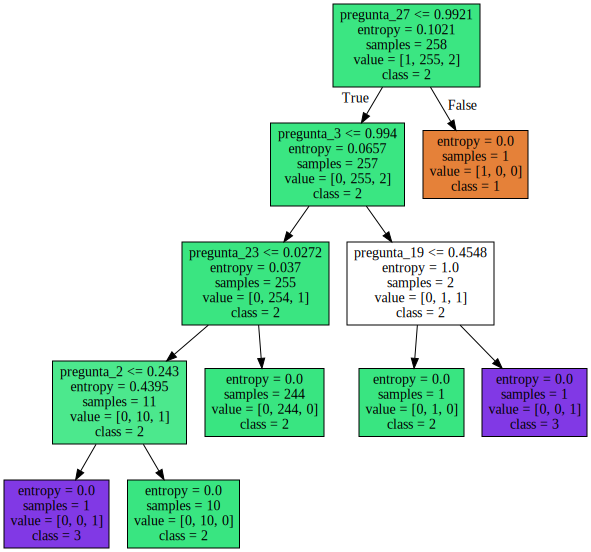

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Edad  ingresoef  pregunta_1  pregunta_2  pregunta_3  pregunta_4  \
4     36          0    0.945418    0.833204    0.601921    0.857995   
5     43          0    0.469796    0.874347    0.613986    0.975214   
7     41          0    0.137555    0.787741    0.155432    0.278163   
10    49          0    0.832347    0.064413    0.386503    0.915506   
15    32          0    0.222938    0.129518    0.155241    0.203387   

    pregunta_5  pregunta_6  pregunta_7  pregunta_8   ...    \
4     0.926111    0.913815    0.609726    0.990892   ...     
5     0.434296    0.976213    0.565399    0.018880   ...     
7     0.120059    0.672811    0.560806    0.962164   ...     
10    0.585383    0.706981    0.259823    0.475864   ...     
15    0.391220    0.027578    0.392845    0.588458   ...     

    D__ASESOR COMERCIAL JUNIOR 1  D__ASESOR COMERCIAL JUNIOR 2  \
4                              0                             0   
5                              0                             0   
7                              0                             0   
10                             1                             0   
15                             0                             0   

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
4                            0                           0            1   
5                            1                           0            1   
7                            0                           0            0   
10                           0                           0            1   
15                           0                           1            0   

    D__Masculino  D__Casado  D__Otros  D__Soltero  TARGET  
4              0          0         0           1       1  
5              0          0         0           1       1  
7              1          0         0           1       1  
10             0          0         0           1       1  
15             1          0         0           1       1  

[5 rows x 43 columns]

4     1.0
5     1.0
7     1.0
10    1.0
15    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

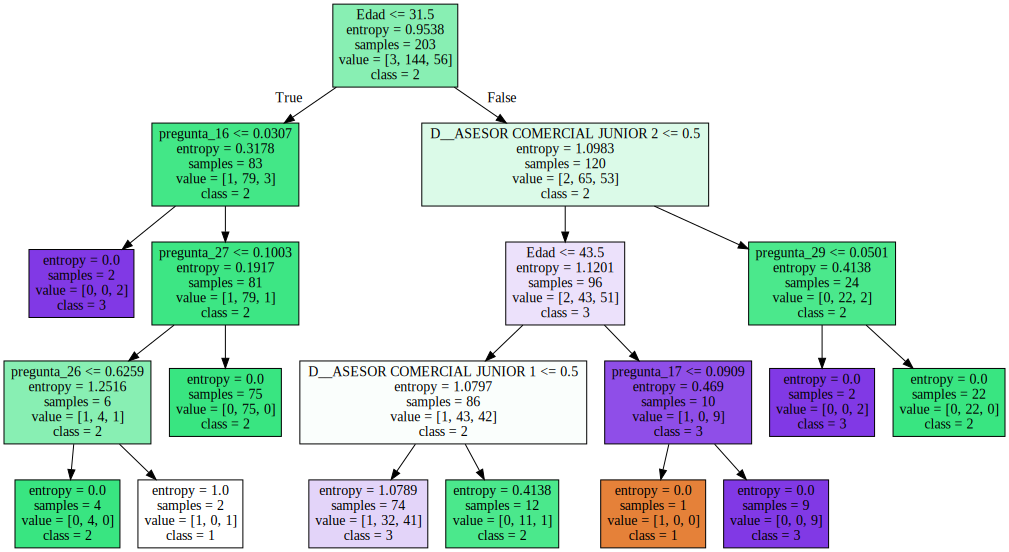

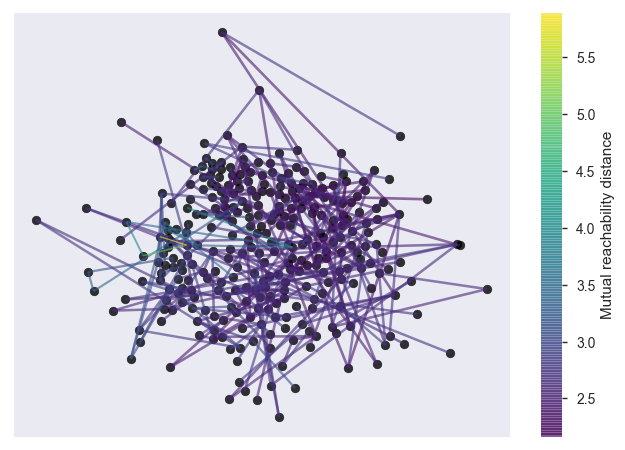

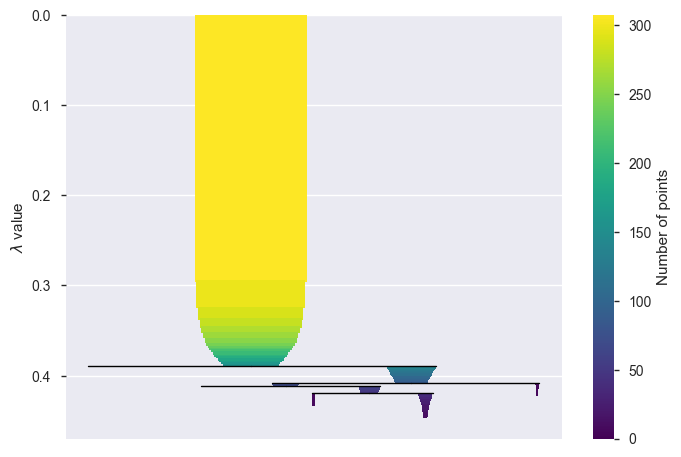

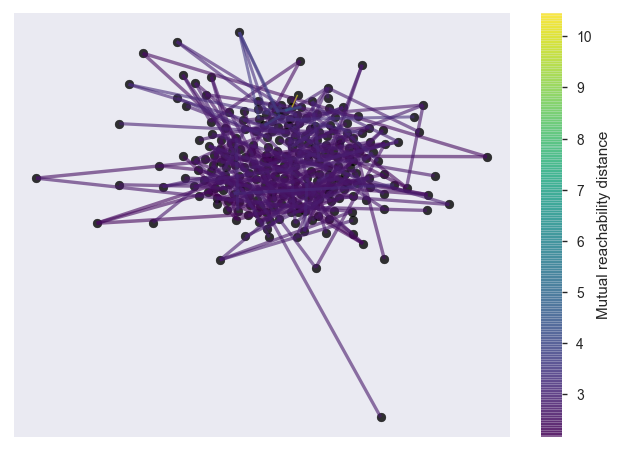

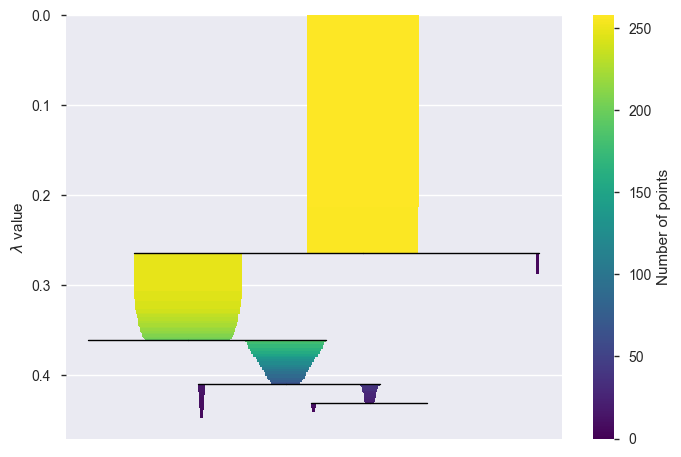

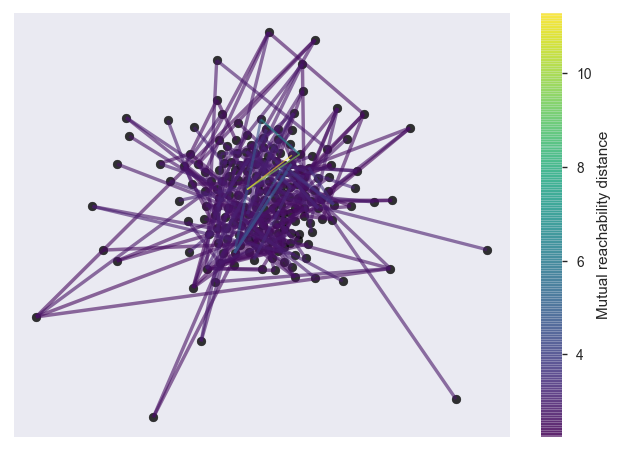

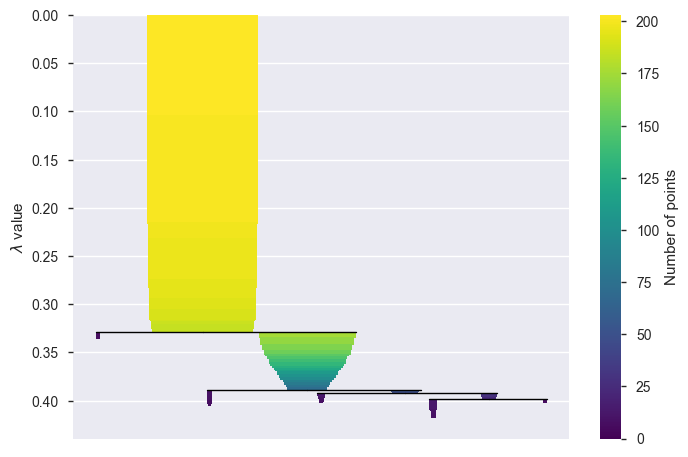

In [35]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

In [36]:
X.shape, y.shape

((768, 43), (768,))

In [37]:
X.to_csv('hk1_X.csv', index=False)
y.to_csv('hk1_y.csv', index=False)

# Cross-validation

In [38]:
eval_size = 0.1
kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [39]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 43), (690,))

((78, 43), (78,))

In [40]:
def increase_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] + value

    before = model.predict(temp)[0]
    temp.loc[feature] += value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nIncreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

In [41]:
def decrease_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] - value

    before = model.predict(temp)[0]
    temp.loc[feature] -= value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nDecreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

# Models

In [42]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [43]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'is_unbalance': False,
 'learning_rate': 0.04,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 30,
 'objective': 'multiclass',
 'reg_alpha': 1,
 'reg_lambda': 6,
 'seed': 777,
 'subsample': 0.9}

Recall: 0.7419354838709677
Precision: 0.46938775510204084
Accuracy: 0.44871794871794873


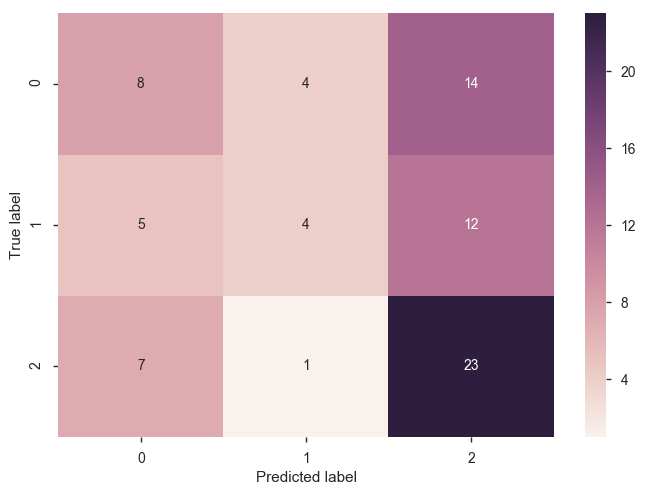

In [44]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09663
[2]	valid_0's multi_logloss: 1.09624
[3]	valid_0's multi_logloss: 1.09544
[4]	valid_0's multi_logloss: 1.09406
[5]	valid_0's multi_logloss: 1.09337
[6]	valid_0's multi_logloss: 1.09424
[7]	valid_0's multi_logloss: 1.09358
[8]	valid_0's multi_logloss: 1.09371
[9]	valid_0's multi_logloss: 1.09243
[10]	valid_0's multi_logloss: 1.09287
[11]	valid_0's multi_logloss: 1.09416
[12]	valid_0's multi_logloss: 1.09316
[13]	valid_0's multi_logloss: 1.09047
[14]	valid_0's multi_logloss: 1.08809
[15]	valid_0's multi_logloss: 1.08625
[16]	valid_0's multi_logloss: 1.08572
[17]	valid_0's multi_logloss: 1.08399
[18]	valid_0's multi_logloss: 1.08388
[19]	valid_0's multi_logloss: 1.08346
[20]	valid_0's multi_logloss: 1.08295
[21]	valid_0's multi_logloss: 1.08354
[22]	valid_0's multi_logloss: 1.08272
[23]	valid_0's multi_logloss: 1.08255
[24]	valid_0's multi_logloss: 1.08287
[25]	valid_0's multi_logloss: 1.08217
[26]	valid_0's multi_logloss: 1.08188
[27]	valid_0's multi_

Recall: 0.5483870967741935
Precision: 0.53125
Accuracy: 0.44871794871794873


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


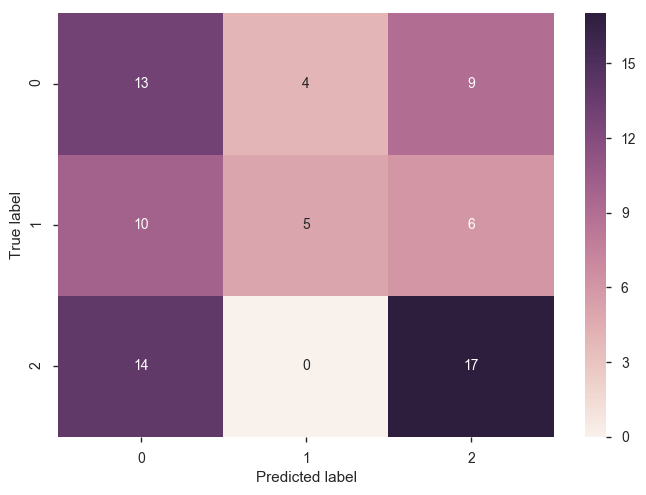

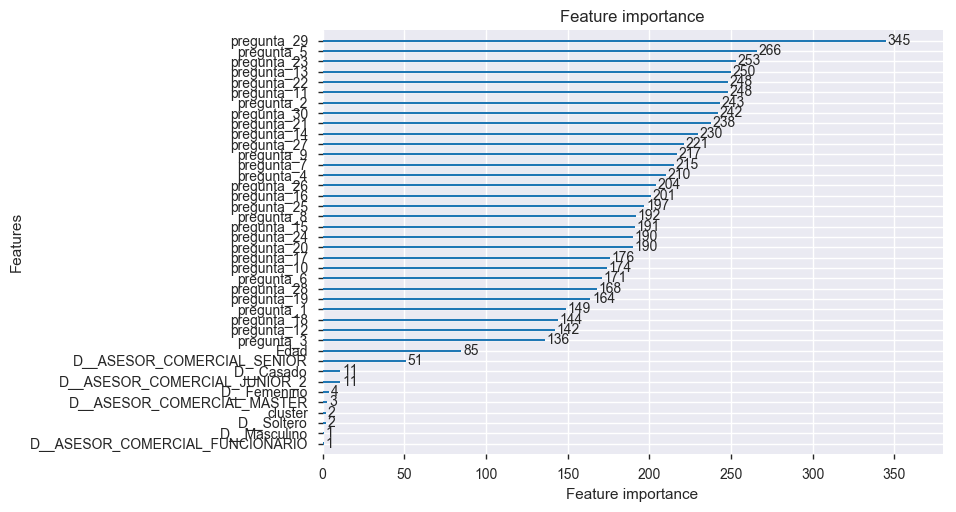

In [45]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

### LIME using LightGBM

In [46]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict)
exp.show_in_notebook(show_table=True, show_all=False)
temp = X_valid.iloc[i].copy()
for feature in X_valid.columns:
    increase_value(feature, temp, 10)
    decrease_value(feature, temp, 20)


Increasing Edad
From 33.0 to 43.0
Before: [ 0.41180905  0.18861368  0.39957727] (class 0)
 After: [ 0.40906903  0.19752216  0.39340881] (class 0)

Decreasing Edad
From 43.0 to 23.0
Before: [ 0.40906903  0.19752216  0.39340881] (class 0)
 After: [ 0.41277343  0.18554751  0.40167907] (class 0)

Increasing pregunta_1
From 0.26520459090221515 to 10.265204590902215
Before: [ 0.41277343  0.18554751  0.40167907] (class 0)
 After: [ 0.40449912  0.18445685  0.41104403] (class 2)

Decreasing pregunta_1
From 10.265204590902215 to -9.734795409097785
Before: [ 0.40449912  0.18445685  0.41104403] (class 2)
 After: [ 0.40105317  0.19373821  0.40520862] (class 2)

Increasing pregunta_2
From 0.3474972041807709 to 10.34749720418077
Before: [ 0.40105317  0.19373821  0.40520862] (class 2)
 After: [ 0.34464125  0.1592772   0.49608155] (class 2)

Decreasing pregunta_2
From 10.34749720418077 to -9.65250279581923
Before: [ 0.34464125  0.1592772   0.49608155] (class 2)
 After: [ 0.37825091  0.26942365  0.3523

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:423: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 100,
 'n_estimators': 120}

Recall: 0.8387096774193549
Precision: 0.3939393939393939
Accuracy: 0.358974358974359


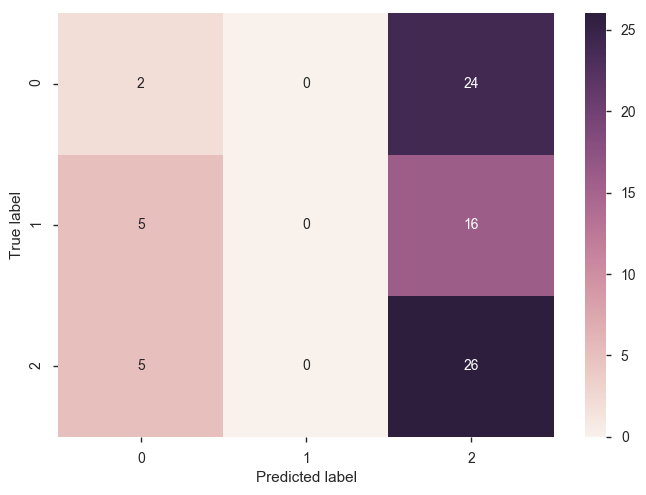

In [47]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.8387096774193549
Precision: 0.3939393939393939
Accuracy: 0.358974358974359
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


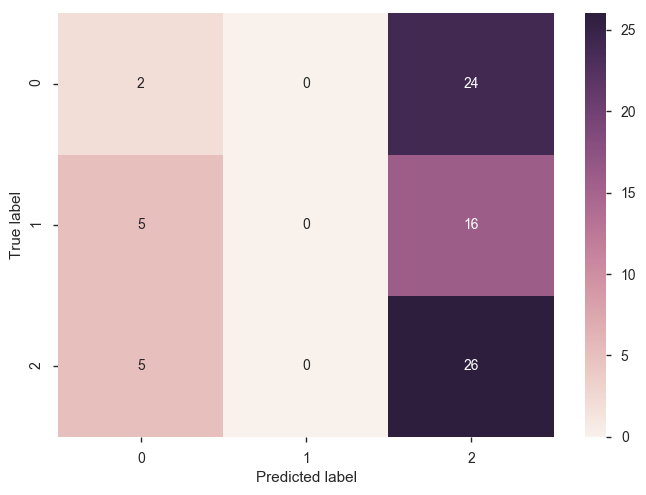

In [48]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

### LIME using Random Forests

In [49]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1200}

Recall: 0.8064516129032258
Precision: 0.38461538461538464
Accuracy: 0.3717948717948718


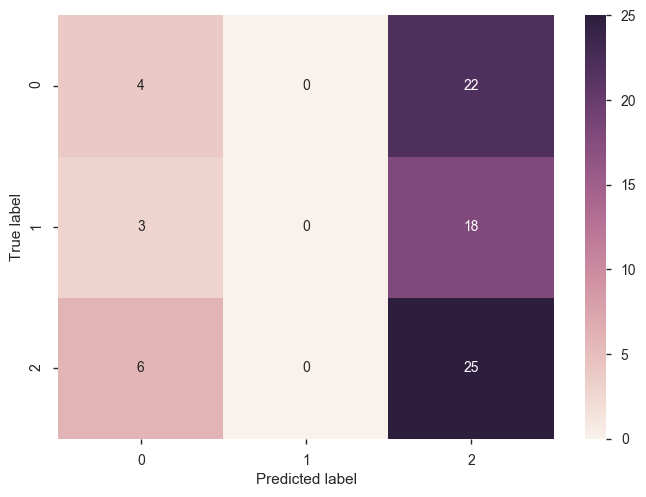

In [50]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1200, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.8064516129032258
Precision: 0.38461538461538464
Accuracy: 0.3717948717948718
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


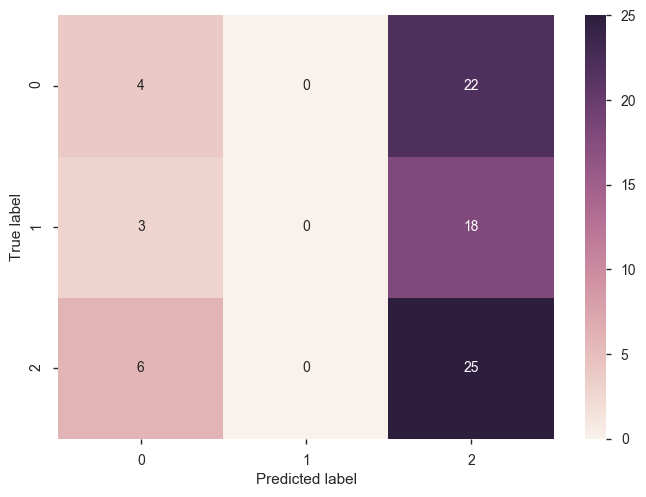

In [51]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### LIME using Extra Trees

In [52]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

### Garbage collection

In [53]:
del DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomizedSearchCV, RFE, SVG, Source, StratifiedKFold
del X, y, X_cluster, X_target, X_train, X_valid, accuracy, accuracy_score, categories, clf, cluster_colors, clusterer, cm
del confusion_matrix, convert_score, cuts, d, d_train, d_valid, df_categorical, df_continuous, df_discrete, df_numeric, dtc
del dtypes, estimator, eval_size, export_graphviz, f1_score, fe_entropy, fe_rfe, feature, g, graph, hdbscan
del i, kf, lgb, make_correlation_graphic, margin1, margin2, model, pair_vars, pandas_profiling, param_grid
del precision, precision_score, recall, recall_score, row, selector, target_class, train_ix, valid_ix, y_cluster, y_pred
del y_pred_trunc, y_train, y_valid
collect()

820

# Results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


entropy  rfe  N_entropy     N_rfe     score
D__ASESOR COMERCIAL SENIOR       0.043496   32   0.270703  0.223258  0.493961
D__ASESOR COMERCIAL JUNIOR 2     0.032533   37   0.202474  0.258142  0.460616
pregunta_29                      0.037530   21   0.233577  0.146513  0.380090
ingresoef                        0.020078   36   0.124959  0.251166  0.376125
cluster                          0.027078   28   0.168524  0.195351  0.363875
D__Femenino                      0.018518   35   0.115251  0.244189  0.359440
pregunta_13                      0.024441   27   0.152113  0.188374  0.340487
D__Otros                         0.010919   38   0.067958  0.265119  0.333077
pregunta_10                      0.025327   25   0.157628  0.174420  0.332049
D__Masculino                     0.020185   29   0.125623  0.202328  0.327951
D__Soltero                       0.017689   31   0.110088  0.216281  0.326370
pregunta_16                      0.028636   20   0.178218  0.139536  0.317755
pregunta_30                      0.030125   18   0.187486  0.125583  0.313069
pregunta_28                      0.022710   24   0.141337  0.167444  0.308781
D__ASESOR COMERCIAL JUNIOR 1     0.015894   30   0.098917  0.209305  0.308222
pregunta_12                      0.020344   26   0.126612  0.181397  0.308009
D__Casado                        0.012261   33   0.076306  0.230235  0.306541
D__ASESOR COMERCIAL MASTER       0.010140   34   0.063108  0.237212  0.300320
D__ASESOR COMERCIAL FUNCIONARIO  0.003343   39   0.020803  0.272096  0.292899
pregunta_3                       0.021071   22   0.131137  0.153490  0.284627
pregunta_9                       0.019556   23   0.121711  0.160467  0.282178
pregunta_11                      0.024606   16   0.153141  0.111629  0.264771
pregunta_15                      0.025612   15   0.159400  0.104652  0.264053
pregunta_7                       0.023303   17   0.145033  0.118606  0.263639
pregunta_27                      0.039277    1   0.244444  0.006977  0.251421
pregunta_2                       0.029686    9   0.184755  0.062791  0.247547
pregunta_21                      0.024138   13   0.150227  0.090699  0.240925
pregunta_5                       0.036364    1   0.226316  0.006977  0.233292
pregunta_20                      0.021281   14   0.132446  0.097675  0.230122
pregunta_23                      0.034558    1   0.215074  0.006977  0.222051
Edad                             0.013696   19   0.085240  0.132560  0.217799
pregunta_18                      0.025988    8   0.161738  0.055815  0.217552
pregunta_24                      0.021345   12   0.132845  0.083722  0.216567
pregunta_8                       0.022106   11   0.137583  0.076745  0.214328
pregunta_22                      0.026455    7   0.164649  0.048838  0.213487
pregunta_6                       0.020179   10   0.125589  0.069768  0.195358
pregunta_4                       0.021976    6   0.136770  0.041861  0.178631
pregunta_1                       0.020417    5   0.127071  0.034884  0.161955
pregunta_17                      0.021390    3   0.133127  0.020930  0.154058
pregunta_14                      0.022502    2   0.140047  0.013954  0.154000
pregunta_25                      0.020176    4   0.125567  0.027907  0.153474
pregunta_26                      0.023416    1   0.145734  0.006977  0.152710
pregunta_19                      0.019656    1   0.122329  0.006977  0.129306

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

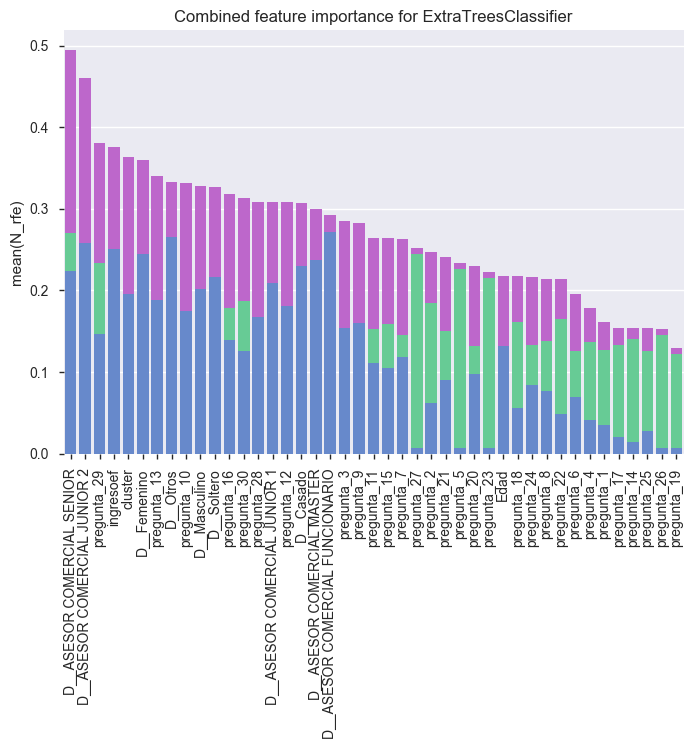

In [54]:
df1 = pd.DataFrame(model_results['extra_trees']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['extra_trees']['fe_rfe']).set_index(0)
results_extra_trees = pd.concat([df1, df2], axis=1)

results_extra_trees.columns = ['entropy', 'rfe']
results_extra_trees['N_entropy'] = normalize(results_extra_trees['entropy'])[0]
results_extra_trees['N_rfe'] = normalize(results_extra_trees['rfe'])[0]

results_extra_trees['score'] = results_extra_trees['N_entropy'] + results_extra_trees['N_rfe']

results_extra_trees = results_extra_trees.sort_values('score', ascending=False)

results_extra_trees

plt.title('Combined feature importance for ExtraTreesClassifier')
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


entropy  rfe  N_entropy     N_rfe     score
pregunta_13                      0.053470   22   0.277797  0.153490  0.431288
pregunta_23                      0.056327   11   0.292640  0.076745  0.369385
pregunta_8                       0.033799   25   0.175600  0.174420  0.350021
pregunta_5                       0.061373    1   0.318858  0.006977  0.325835
pregunta_30                      0.055968    5   0.290779  0.034884  0.325663
pregunta_4                       0.026551   26   0.137943  0.181397  0.319341
pregunta_16                      0.033595   16   0.174540  0.111629  0.286169
pregunta_3                       0.028773   19   0.149487  0.132560  0.282046
D__ASESOR COMERCIAL FUNCIONARIO  0.000876   39   0.004550  0.272096  0.276646
pregunta_6                       0.020774   24   0.107929  0.167444  0.275373
pregunta_29                      0.051659    1   0.268392  0.006977  0.275369
D__ASESOR COMERCIAL JUNIOR 2     0.007231   34   0.037566  0.237212  0.274777
pregunta_1                       0.021786   23   0.113185  0.160467  0.273652
pregunta_2                       0.041691    8   0.216599  0.055815  0.272414
cluster                          0.000000   38   0.000000  0.265119  0.265119
pregunta_18                      0.037317   10   0.193877  0.069768  0.263646
D__ASESOR COMERCIAL SENIOR       0.013048   28   0.067790  0.195351  0.263141
pregunta_14                      0.048723    1   0.253136  0.006977  0.260113
D__Casado                        0.000000   37   0.000000  0.258142  0.258142
D__ASESOR COMERCIAL MASTER       0.000000   36   0.000000  0.251166  0.251166
D__Femenino                      0.000000   35   0.000000  0.244189  0.244189
pregunta_17                      0.017487   21   0.090850  0.146513  0.237363
D__Otros                         0.000796   33   0.004135  0.230235  0.234370
pregunta_25                      0.022163   17   0.115144  0.118606  0.233750
pregunta_21                      0.039428    4   0.204844  0.027907  0.232751
pregunta_27                      0.043144    1   0.224152  0.006977  0.231129
ingresoef                        0.002805   31   0.014571  0.216281  0.230853
D__ASESOR COMERCIAL JUNIOR 1     0.000785   32   0.004078  0.223258  0.227336
Edad                             0.007198   27   0.037396  0.188374  0.225770
D__Soltero                       0.002501   30   0.012994  0.209305  0.222299
pregunta_20                      0.025530   12   0.132637  0.083722  0.216359
pregunta_10                      0.023038   13   0.119694  0.090699  0.210393
pregunta_9                       0.019550   15   0.101572  0.104652  0.206225
D__Masculino                     0.000000   29   0.000000  0.202328  0.202328
pregunta_28                      0.011996   20   0.062325  0.139536  0.201862
pregunta_7                       0.029531    6   0.153423  0.041861  0.195284
pregunta_22                      0.033139    3   0.172172  0.020930  0.193103
pregunta_12                      0.011897   18   0.061812  0.125583  0.187395
pregunta_11                      0.022873    9   0.118833  0.062791  0.181624
pregunta_19                      0.024108    7   0.125250  0.048838  0.174088
pregunta_15                      0.031320    1   0.162720  0.006977  0.169697
pregunta_24                      0.011402   14   0.059241  0.097675  0.156916
pregunta_26                      0.026350    2   0.136897  0.013954  0.150851

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

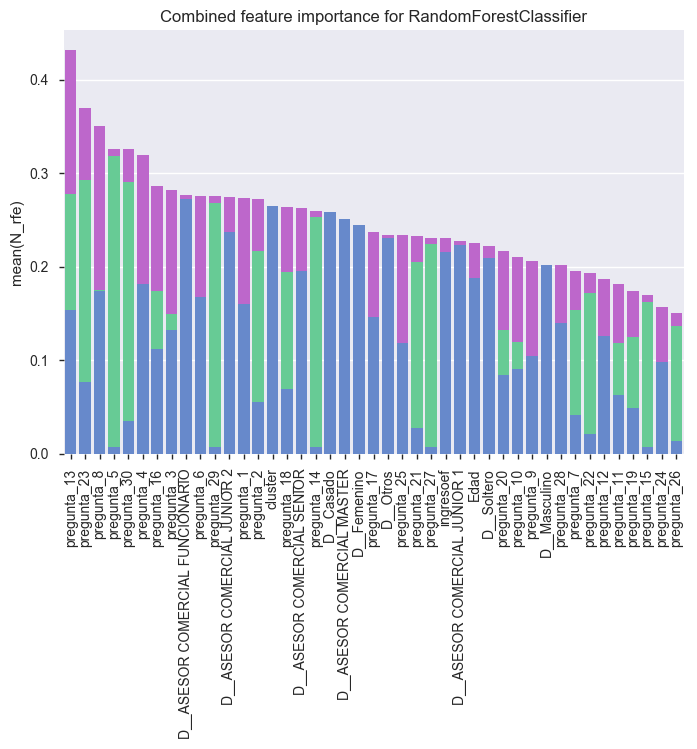

In [55]:
df1 = pd.DataFrame(model_results['random_forest']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['random_forest']['fe_rfe']).set_index(0)
results_random_forest = pd.concat([df1, df2], axis=1)

results_random_forest.columns = ['entropy', 'rfe']
results_random_forest['N_entropy'] = normalize(results_random_forest['entropy'])[0]
results_random_forest['N_rfe'] = normalize(results_random_forest['rfe'])[0]

results_random_forest['score'] = results_random_forest['N_entropy'] + results_random_forest['N_rfe']

results_random_forest = results_random_forest.sort_values('score', ascending=False)

results_random_forest

plt.title('Combined feature importance for RandomForestClassifier')
sns.barplot(x=results_random_forest.index, y=results_random_forest['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

0  pregunta_29  pregunta_5  pregunta_23  pregunta_13  pregunta_11  \
1          345         266          253          250          248   

0  pregunta_22  pregunta_2  pregunta_30  pregunta_21  pregunta_14    ...     \
1          248         243          242          238          230    ...      

0  D__Casado  D__Femenino  D__ASESOR_COMERCIAL_MASTER  D__Soltero  cluster  \
1         11            4                           3           2        2   

0  D__ASESOR_COMERCIAL_FUNCIONARIO  D__Masculino  ingresoef  \
1                                1             1          0   

0  D__ASESOR_COMERCIAL_JUNIOR_1  D__Otros  
1                             0         0  

[1 rows x 43 columns]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


entropy  rfe  N_entropy     N_rfe     score
pregunta_13                          250   21   0.214658  0.146513  0.361171
pregunta_10                          174   26   0.149402  0.181397  0.330799
pregunta_25                          197   23   0.169151  0.160467  0.329617
pregunta_21                          238   17   0.204354  0.118606  0.322960
pregunta_1                           149   27   0.127936  0.188374  0.316310
pregunta_28                          168   24   0.144250  0.167444  0.311694
pregunta_14                          230   16   0.197485  0.111629  0.309114
pregunta_30                          242   14   0.207789  0.097675  0.305464
pregunta_29                          345    1   0.296228  0.006977  0.303205
pregunta_11                          248   11   0.212941  0.076745  0.289686
pregunta_6                           171   20   0.146826  0.139536  0.286362
pregunta_22                          248   10   0.212941  0.069768  0.282709
pregunta_17                          176   18   0.151119  0.125583  0.276702
D__Otros                               0   39   0.000000  0.272096  0.272096
pregunta_3                           136   22   0.116774  0.153490  0.270264
pregunta_9                           217   12   0.186323  0.083722  0.270045
D__ASESOR COMERCIAL MASTER             3   38   0.002576  0.265119  0.267695
pregunta_2                           243    8   0.208648  0.055815  0.264462
D__ASESOR COMERCIAL JUNIOR 1           0   37   0.000000  0.258142  0.258142
pregunta_18                          144   19   0.123643  0.132560  0.256203
ingresoef                              0   36   0.000000  0.251166  0.251166
Edad                                  85   25   0.072984  0.174420  0.247404
pregunta_19                          164   15   0.140816  0.104652  0.245468
D__Masculino                           1   35   0.000859  0.244189  0.245047
D__ASESOR COMERCIAL SENIOR            51   28   0.043790  0.195351  0.239141
D__ASESOR COMERCIAL FUNCIONARIO        1   34   0.000859  0.237212  0.238071
pregunta_26                          204    9   0.175161  0.062791  0.237952
pregunta_5                           266    1   0.228396  0.006977  0.235373
cluster                                2   33   0.001717  0.230235  0.231952
D__Femenino                            4   32   0.003435  0.223258  0.226693
pregunta_23                          253    1   0.217234  0.006977  0.224211
D__ASESOR COMERCIAL JUNIOR 2          11   30   0.009445  0.209305  0.218750
D__Soltero                             2   31   0.001717  0.216281  0.217999
pregunta_4                           210    5   0.180313  0.034884  0.215197
pregunta_12                          142   13   0.121926  0.090699  0.212624
pregunta_20                          190    7   0.163140  0.048838  0.211978
D__Casado                             11   29   0.009445  0.202328  0.211773
pregunta_15                          191    6   0.163999  0.041861  0.205860
pregunta_27                          221    1   0.189758  0.006977  0.196734
pregunta_16                          201    3   0.172585  0.020930  0.193515
pregunta_8                           192    4   0.164857  0.027907  0.192765
pregunta_7                           215    1   0.184606  0.006977  0.191583
pregunta_24                          190    2   0.163140  0.013954  0.177094

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

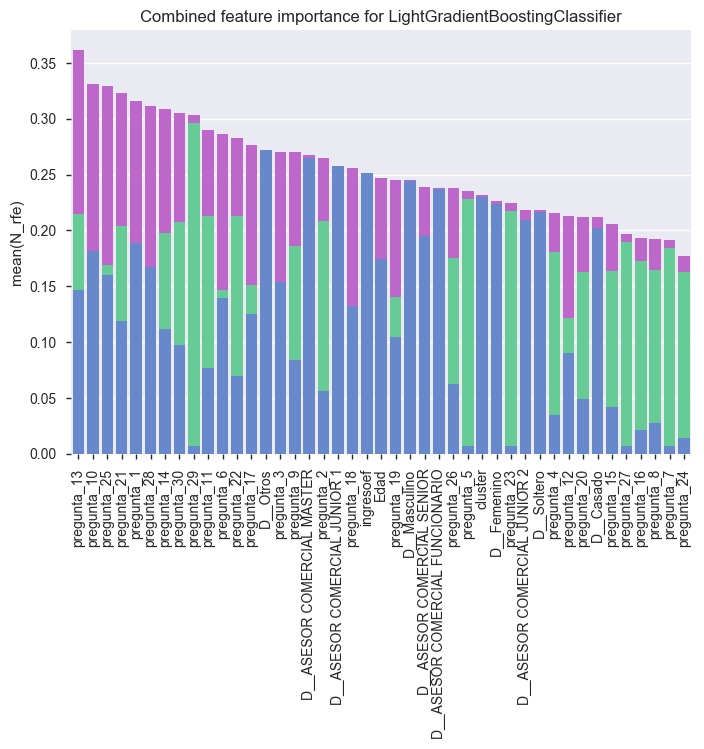

In [56]:
df1 = pd.DataFrame(model_results['lightgbm']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['lightgbm']['fe_rfe']).set_index(0)

df1 = df1.T
df1

for feature in [col for col in df1.columns if col.startswith('D_')]:
    df1 = df1.rename(columns={
        feature: feature.replace('_', ' ').replace('D  ', 'D__')
    })

df1 = df1.T
    
results_lightgbm = pd.concat([df1, df2], axis=1)

results_lightgbm.columns = ['entropy', 'rfe']
results_lightgbm['N_entropy'] = normalize(results_lightgbm['entropy'])[0]
results_lightgbm['N_rfe'] = normalize(results_lightgbm['rfe'])[0]

results_lightgbm['score'] = results_lightgbm['N_entropy'] + results_lightgbm['N_rfe']

results_lightgbm = results_lightgbm.sort_values('score', ascending=False)

results_lightgbm

plt.title('Combined feature importance for LightGradientBoostingClassifier')
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

extra_trees  random_forest  lightgbm  \
pregunta_13                         0.340487       0.431288  0.361171   
D__ASESOR COMERCIAL SENIOR          0.493961       0.263141  0.239141   
pregunta_29                         0.380090       0.275369  0.303205   
D__ASESOR COMERCIAL JUNIOR 2        0.460616       0.274777  0.218750   
pregunta_30                         0.313069       0.325663  0.305464   
pregunta_10                         0.332049       0.210393  0.330799   
cluster                             0.363875       0.265119  0.231952   
ingresoef                           0.376125       0.230853  0.251166   
D__Otros                            0.333077       0.234370  0.272096   
pregunta_3                          0.284627       0.282046  0.270264   
D__Femenino                         0.359440       0.244189  0.226693   
pregunta_28                         0.308781       0.201862  0.311694   
D__ASESOR COMERCIAL MASTER          0.300320       0.251166  0.267695   
pregunta_23                         0.222051       0.369385  0.224211   
D__ASESOR COMERCIAL FUNCIONARIO     0.292899       0.276646  0.238071   
pregunta_16                         0.317755       0.286169  0.193515   
pregunta_21                         0.240925       0.232751  0.322960   
pregunta_5                          0.233292       0.325835  0.235373   
D__ASESOR COMERCIAL JUNIOR 1        0.308222       0.227336  0.258142   
pregunta_2                          0.247547       0.272414  0.264462   
D__Casado                           0.306541       0.258142  0.211773   
D__Masculino                        0.327951       0.202328  0.245047   
D__Soltero                          0.326370       0.222299  0.217999   
pregunta_9                          0.282178       0.206225  0.270045   
pregunta_8                          0.214328       0.350021  0.192765   
pregunta_6                          0.195358       0.275373  0.286362   
pregunta_1                          0.161955       0.273652  0.316310   
pregunta_18                         0.217552       0.263646  0.256203   
pregunta_11                         0.264771       0.181624  0.289686   
pregunta_14                         0.154000       0.260113  0.309114   
pregunta_25                         0.153474       0.233750  0.329617   
pregunta_4                          0.178631       0.319341  0.215197   
pregunta_12                         0.308009       0.187395  0.212624   
Edad                                0.217799       0.225770  0.247404   
pregunta_22                         0.213487       0.193103  0.282709   
pregunta_27                         0.251421       0.231129  0.196734   
pregunta_17                         0.154058       0.237363  0.276702   
pregunta_20                         0.230122       0.216359  0.211978   
pregunta_7                          0.263639       0.195284  0.191583   
pregunta_15                         0.264053       0.169697  0.205860   
pregunta_24                         0.216567       0.156916  0.177094   
pregunta_19                         0.129306       0.174088  0.245468   
pregunta_26                         0.152710       0.150851  0.237952   

                                    score  
pregunta_13                      1.132946  
D__ASESOR COMERCIAL SENIOR       0.996243  
pregunta_29                      0.958664  
D__ASESOR COMERCIAL JUNIOR 2     0.954143  
pregunta_30                      0.944197  
pregunta_10                      0.873241  
cluster                          0.860947  
ingresoef                        0.858143  
D__Otros                         0.839544  
pregunta_3                       0.836938  
D__Femenino                      0.830321  
pregunta_28                      0.822336  
D__ASESOR COMERCIAL MASTER       0.819180  
pregunta_23                      0.815647  
D__ASESOR COMERCIAL FUNCIONARIO  0.807616  
pregunta_16                      0.797439  
pregunta_21                      0.796637  
pregunta_5                  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

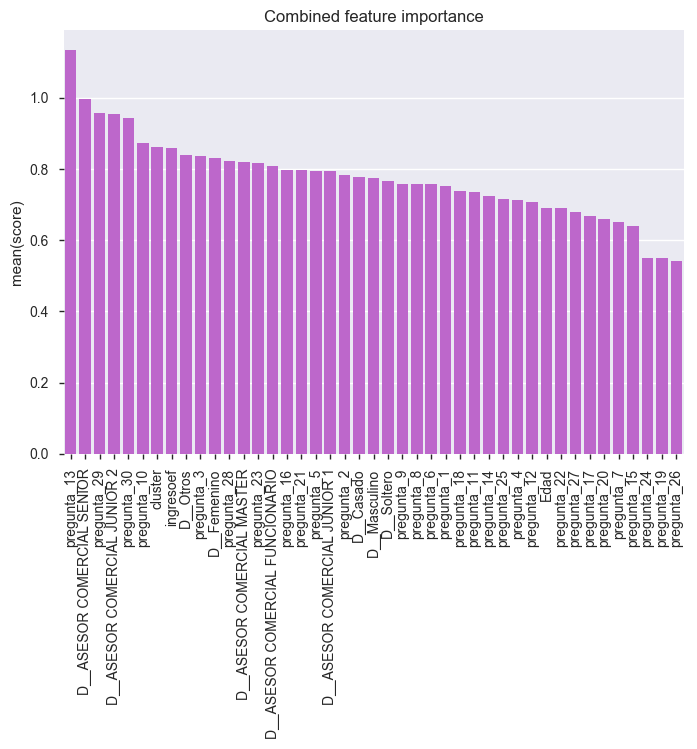

In [57]:
df_results = pd.concat([results_extra_trees['score'], results_random_forest['score'], results_lightgbm['score']], axis=1)
df_results.columns = ['extra_trees', 'random_forest', 'lightgbm']
df_results['score'] = df_results['extra_trees'] + df_results['random_forest'] + df_results['lightgbm']

df_results = df_results.sort_values('score', ascending=False)

df_results

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[4])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

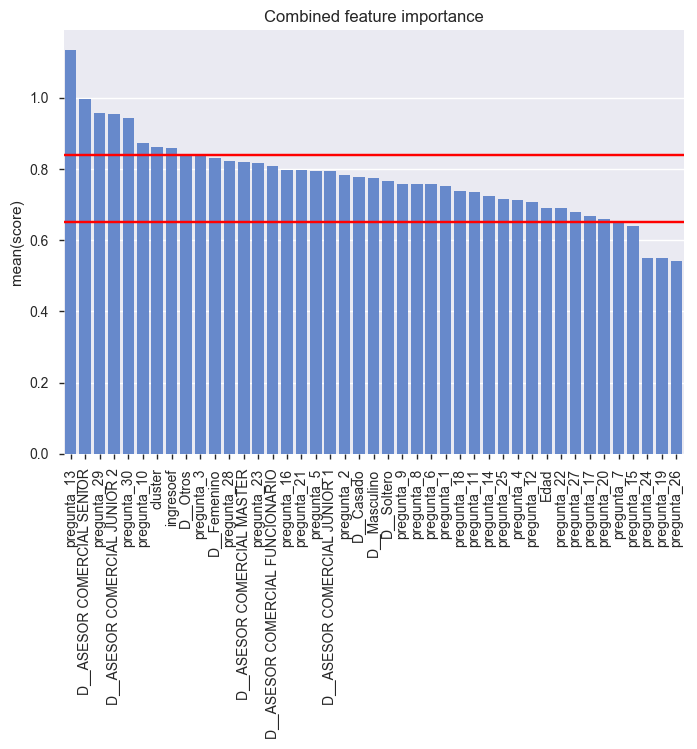

In [58]:
margin1 = 0.1
margin2 = 0.8

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)
sns.plt.axhline(df_results['score'].quantile(margin1), color='r')
sns.plt.axhline(df_results['score'].quantile(margin2), color='r')

In [59]:
categories = ['bad', 'uncertain', 'good']
cuts = [
    min(df_results['score']), 
    df_results['score'].quantile(margin1), 
    df_results['score'].quantile(margin2), 
    max(df_results['score'])
]
df_results['score'] = pd.cut(df_results['score'], cuts, labels=categories, include_lowest=True)
df_results['score']

pregunta_13                             good
D__ASESOR COMERCIAL SENIOR              good
pregunta_29                             good
D__ASESOR COMERCIAL JUNIOR 2            good
pregunta_30                             good
pregunta_10                             good
cluster                                 good
ingresoef                               good
D__Otros                                good
pregunta_3                         uncertain
D__Femenino                        uncertain
pregunta_28                        uncertain
D__ASESOR COMERCIAL MASTER         uncertain
pregunta_23                        uncertain
D__ASESOR COMERCIAL FUNCIONARIO    uncertain
pregunta_16                        uncertain
pregunta_21                        uncertain
pregunta_5                         uncertain
D__ASESOR COMERCIAL JUNIOR 1       uncertain
pregunta_2                         uncertain
D__Casado                          uncertain
D__Masculino                       uncertain
D__Soltero

In [60]:
df_results.to_csv('hk1_initial_pass_results.csv')

In [61]:
uncertain_features = list(df_results.loc[df_results['score'] == 'uncertain'].T.columns)

In [62]:
with open('hk1_uncertain_features.txt', 'wb') as fp:
    pickle.dump(uncertain_features, fp)